In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Cihaz:", device)


Cihaz: cpu


In [2]:
data_dir = r"C:\Users\KER9\Desktop\Derin Öğrenme\NEU-DET"

test_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Mustafa için train transform (CNN yok, sadece basic augmentation)
train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # MLP direkt piksel vektörü görecek
    transforms.Normalize(mean=[0.5], std=[0.5])
])

full_dataset = datasets.ImageFolder(root=data_dir, transform=train_transforms)

print("Sınıflar:", full_dataset.classes)
print("Toplam örnek sayısı:", len(full_dataset))

num_samples = len(full_dataset)
train_size = int(num_samples * 0.7)
val_size   = int(num_samples * 0.15)
test_size  = num_samples - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

val_dataset.dataset.transform = test_transforms
test_dataset.dataset.transform = test_transforms

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")


Sınıflar: ['notebooks', 'train', 'validation']
Toplam örnek sayısı: 1808
Train: 1265, Val: 271, Test: 272


In [3]:
class SimpleMLP_Mustafa(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleMLP_Mustafa, self).__init__()

        self.model = nn.Sequential(
            nn.Flatten(),                       # 224x224 -> 50176
            nn.Linear(224 * 224, 256),          # İlk fully-connected
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 64),                 # Daha küçük katman
            nn.ReLU(),
            nn.Linear(64, num_classes)          # Çıkış katmanı (2 sınıf)
        )

    def forward(self, x):
        return self.model(x)


model_mustafa = SimpleMLP_Mustafa(num_classes=len(full_dataset.classes)).to(device)
print(model_mustafa)


SimpleMLP_Mustafa(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=50176, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=256, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=3, bias=True)
  )
)


In [4]:
criterion = nn.CrossEntropyLoss()
optimizer_mustafa = optim.Adam(model_mustafa.parameters(), lr=0.001)

num_epochs = 10


In [5]:
def train_one_epoch(model, optimizer, criterion, dataloader, device):
    model.train()
    total_loss = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)

    return total_loss / len(dataloader.dataset)


def evaluate(model, criterion, dataloader, device):
    model.eval()
    total_loss = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)

            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average="macro", zero_division=0)
    rec  = recall_score(y_true, y_pred, average="macro", zero_division=0)
    f1   = f1_score(y_true, y_pred, average="macro", zero_division=0)

    return total_loss / len(dataloader.dataset), acc, prec, rec, f1, y_true, y_pred


In [6]:
train_losses_m = []
val_losses_m = []
val_accs_m = []
val_f1s_m = []

for epoch in range(num_epochs):
    train_loss = train_one_epoch(model_mustafa, optimizer_mustafa, criterion, train_loader, device)
    val_loss, acc, prec, rec, f1, _, _ = evaluate(model_mustafa, criterion, val_loader, device)

    train_losses_m.append(train_loss)
    val_losses_m.append(val_loss)
    val_accs_m.append(acc)
    val_f1s_m.append(f1)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss:   {val_loss:.4f}")
    print(f"  Val Acc:    {acc:.4f}")
    print(f"  Val F1:     {f1:.4f}")
    print("-" * 40)


Epoch 1/10
  Train Loss: 1.5411
  Val Loss:   1.3368
  Val Acc:    0.7122
  Val F1:     0.4484
----------------------------------------
Epoch 2/10
  Train Loss: 0.8892
  Val Loss:   1.1764
  Val Acc:    0.7122
  Val F1:     0.3157
----------------------------------------
Epoch 3/10
  Train Loss: 0.6875
  Val Loss:   1.1307
  Val Acc:    0.7269
  Val F1:     0.4226
----------------------------------------
Epoch 4/10
  Train Loss: 0.5776
  Val Loss:   1.1344
  Val Acc:    0.7269
  Val F1:     0.4137
----------------------------------------
Epoch 5/10
  Train Loss: 0.5200
  Val Loss:   1.0380
  Val Acc:    0.7306
  Val F1:     0.4236
----------------------------------------
Epoch 6/10
  Train Loss: 0.5419
  Val Loss:   1.4100
  Val Acc:    0.7085
  Val F1:     0.4332
----------------------------------------
Epoch 7/10
  Train Loss: 0.5211
  Val Loss:   1.1552
  Val Acc:    0.7343
  Val F1:     0.4154
----------------------------------------
Epoch 8/10
  Train Loss: 0.4947
  Val Loss:   1.

In [7]:
test_loss_m, test_acc_m, test_prec_m, test_rec_m, test_f1_m, y_true_m, y_pred_m = evaluate(
    model_mustafa, criterion, test_loader, device
)

print("=== TEST SONUÇLARI (MUSTAFA - MLP) ===")
print(f"Test Loss:      {test_loss_m:.4f}")
print(f"Test Accuracy:  {test_acc_m:.4f}")
print(f"Test Precision: {test_prec_m:.4f}")
print(f"Test Recall:    {test_rec_m:.4f}")
print(f"Test F1 Score:  {test_f1_m:.4f}")

print("\nSınıf Bazlı Rapor:")
print(classification_report(y_true_m, y_pred_m, target_names=full_dataset.classes, zero_division=0))


=== TEST SONUÇLARI (MUSTAFA - MLP) ===
Test Loss:      0.6644
Test Accuracy:  0.8199
Test Precision: 0.6955
Test Recall:    0.5063
Test F1 Score:  0.5478

Sınıf Bazlı Rapor:
              precision    recall  f1-score   support

   notebooks       1.00      0.50      0.67         2
       train       0.84      0.97      0.90       226
  validation       0.25      0.05      0.08        44

    accuracy                           0.82       272
   macro avg       0.70      0.51      0.55       272
weighted avg       0.74      0.82      0.76       272



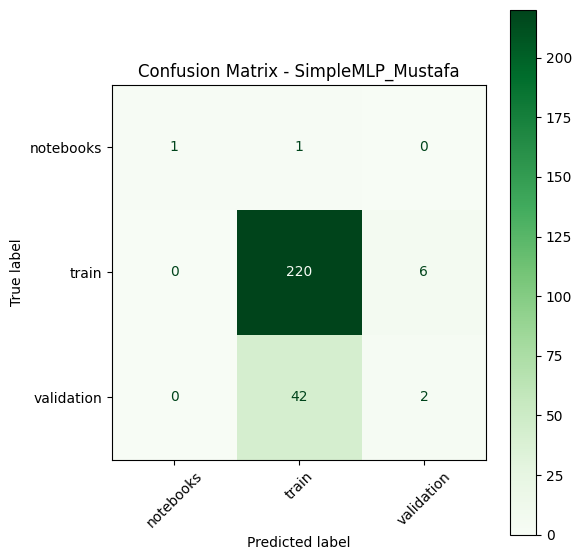

In [8]:
from sklearn.metrics import ConfusionMatrixDisplay

cm_m = confusion_matrix(y_true_m, y_pred_m)

disp_m = ConfusionMatrixDisplay(confusion_matrix=cm_m, display_labels=full_dataset.classes)
fig, ax = plt.subplots(figsize=(6, 6))
disp_m.plot(ax=ax, cmap="Greens", xticks_rotation=45)
plt.title("Confusion Matrix - SimpleMLP_Mustafa")
plt.tight_layout()
plt.show()


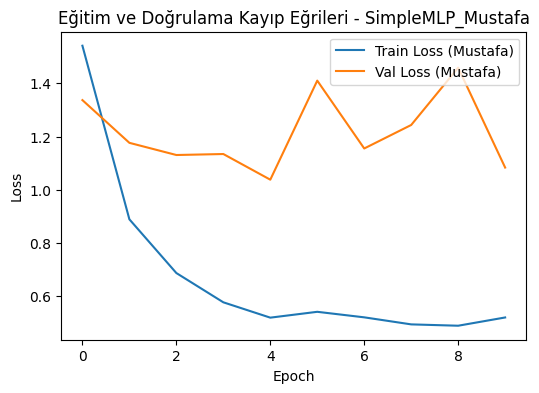

In [9]:
plt.figure(figsize=(6,4))
plt.plot(train_losses_m, label="Train Loss (Mustafa)")
plt.plot(val_losses_m, label="Val Loss (Mustafa)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Eğitim ve Doğrulama Kayıp Eğrileri - SimpleMLP_Mustafa")
plt.legend()
plt.show()
